In [2]:
# Base imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import our package
from neurasort.bio482.helpers import *

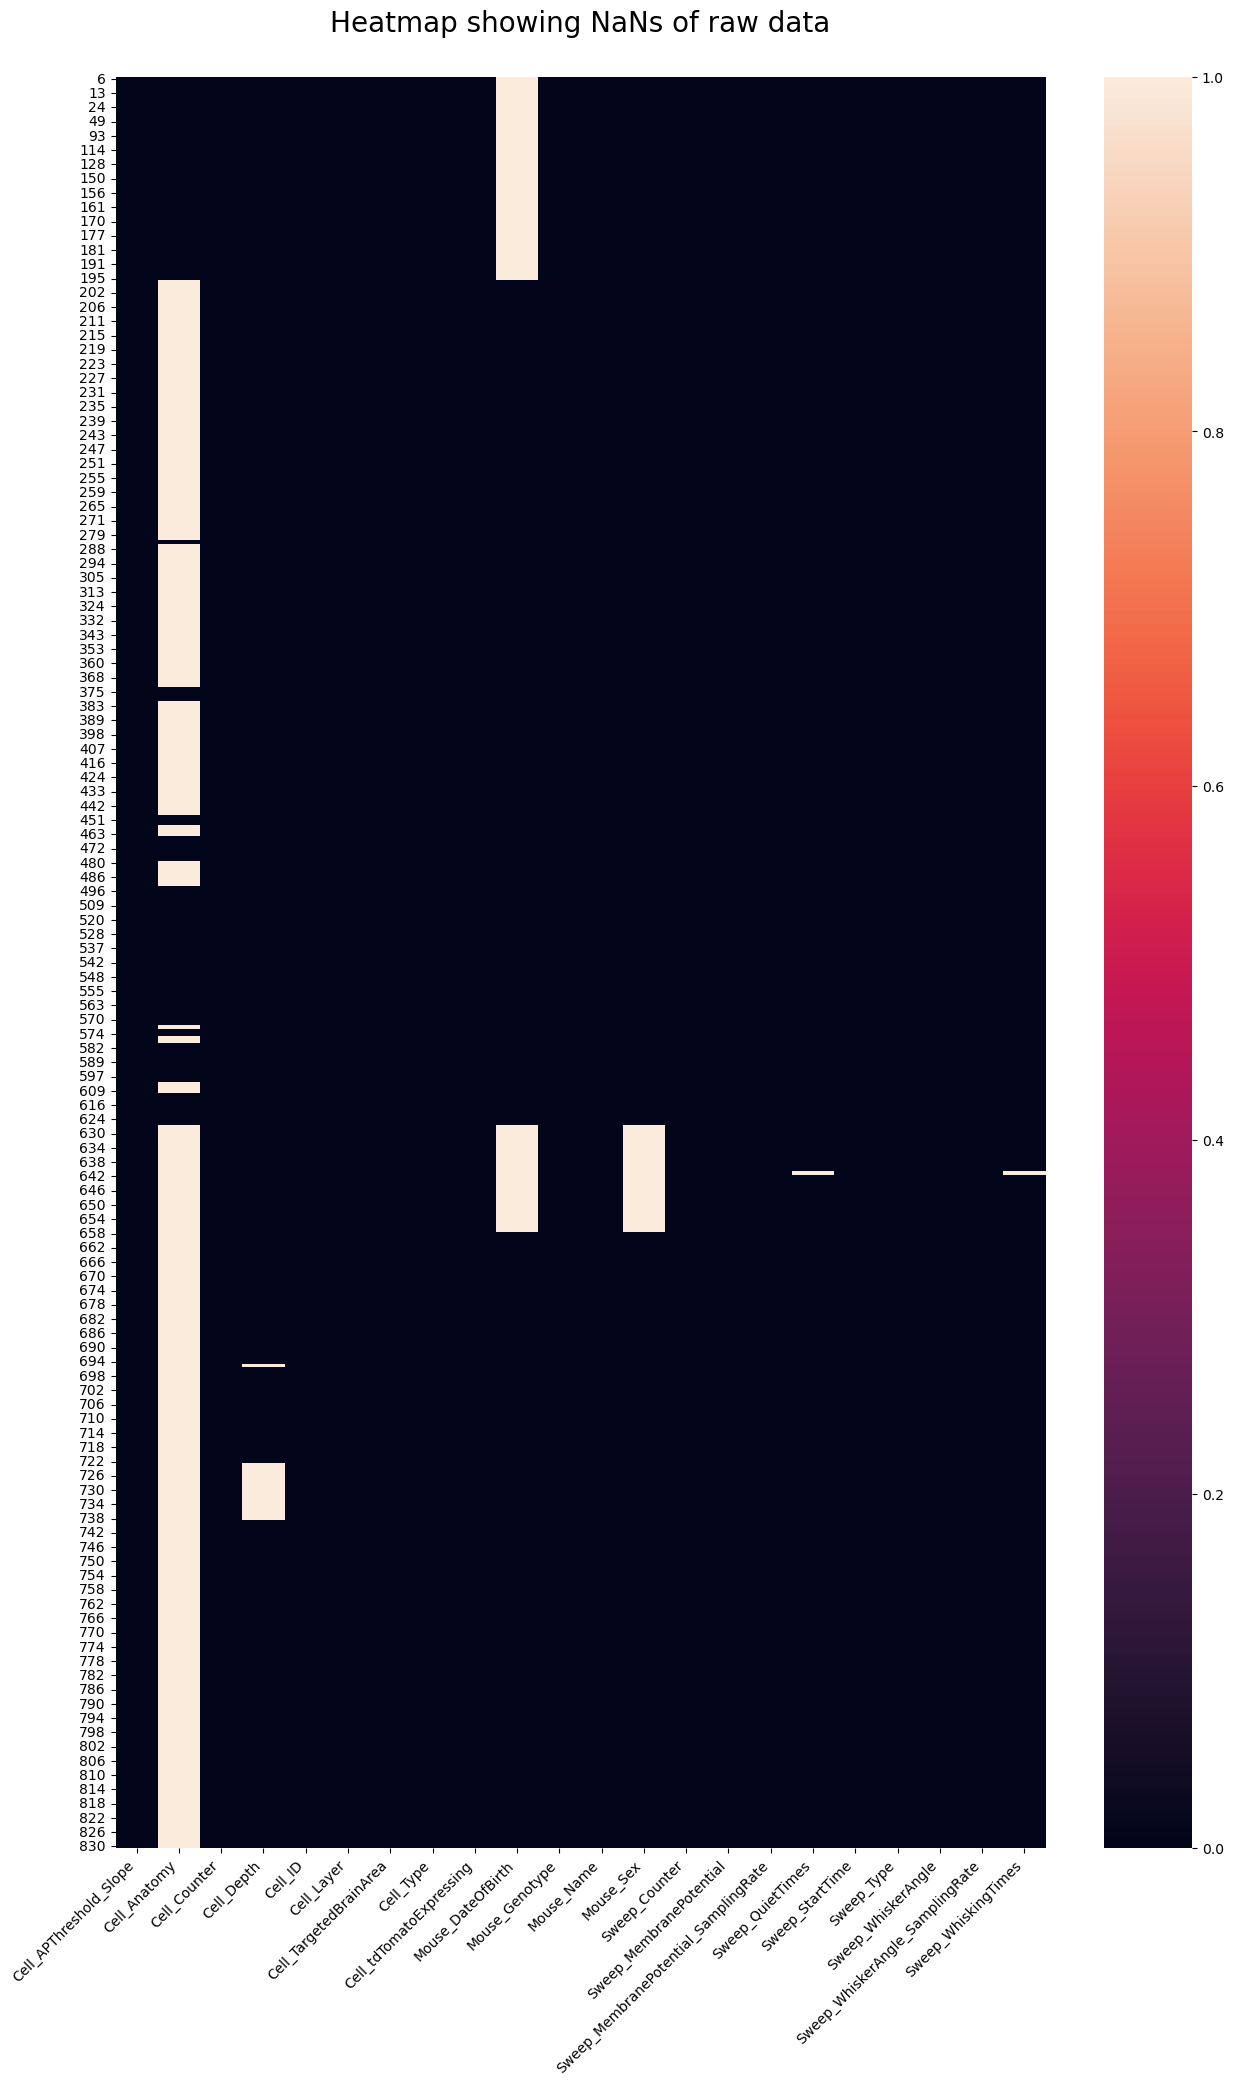

In [10]:
# Import raw data
raw_data = pd.read_pickle("Data/data_bio482.pkl")
# Remove initially useless columns
data_processed = raw_data.drop(["Sweep_PassiveContactTimes", "Sweep_ActiveContactTimes"], axis=1)
# Process data a bit
columns_with_arrays = [
    "Sweep_MembranePotential",
    "Sweep_QuietTimes",
    "Sweep_WhiskerAngle",
    "Sweep_WhiskingTimes",
]
data_processed[data_processed.columns.difference(columns_with_arrays)] = data_processed[data_processed.columns.difference(columns_with_arrays)].replace('nan', np.nan)
# Get free whisking data
data_free_whisking = data_processed[data_processed['Sweep_Type']=='free whisking']
# Initial exploration of NaNs
plt.figure(figsize=(15,23))
heatmap = sns.heatmap(data_free_whisking.isna())
heatmap.set_title('Heatmap showing NaNs of raw data', fontdict={'fontsize':20}, pad=33)
heatmap.set_xticklabels(labels = heatmap.get_xticklabels(), rotation = 45, ha="right")
plt.savefig("ProjectFigures/nan_heatmap.png", dpi = 500)

In [13]:
# Some params for the feature engineering
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

# Initialize a dictionary to store data for all cells
result_dict = {
    'cell_type': [],
    'firing_rate': [],
    'ap_threshold': [],
    'ap_duration': [],
    'mean_vm': [],
    'std_vm': [],
    'fft_low': [],
    'fft_high': [],
    'ap_amp_mean': [],
    'ap_amp_cv': [],
    'mean_ap_upstroke': [],
    'ap_upstroke_cv': [],
    'mean_ap_downstroke': [],
    'ap_downstroke_cv': [],
    'isi_mean': [],
    'isi_cv': [],
    'irregularity_index': [],
    'adaptation_index': [],
    'nb_bursts': [],
    'mean_burst_dur': [],
    'burst_dur_cv': [],
    'Cell_APThreshold_Slope' : [],
}

result_fft_cell_type = {'EXC': [], 'SST': [], 'VIP': [], 'PV': []}

# Iterate over each row in the DataFrame
for idx, cell_row in data_free_whisking.iterrows():
#for idx, cell_row in data_active_touch.iterrows():

    # Get cell ID and other relevant information from the row
    #cell_id = cell_row['Cell_ID']
    cell_type = cell_row['Cell_Type']
    sr_vm = cell_row['Sweep_MembranePotential_SamplingRate']
    membrane_potential = cell_row['Sweep_MembranePotential']
    ap_vm_deriv_thresh = cell_row['Cell_APThreshold_Slope']
    Cell_APThreshold_Slope = cell_row['Cell_APThreshold_Slope']
    Mouse_Sex = cell_row['Mouse_Sex']
    #Cell_tdTomatoExpressing = cell_row['Cell_tdTomatoExpressing']

    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = len(membrane_potential)/sr_vm
    tot_number_ap = 0

    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration = []
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []

    # Detection of action potentials for that trial, and update total number of APs for that cell
    ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)
    tot_number_ap += ap_params.shape[0]

    # Check if this trial contains any AP...
    ap_duration = []
    if ap_params.any():
        ap_thresh_times = ap_params[:, 0]
        ap_thresh_vm = ap_params[:, 1]
        ap_peak_times = ap_params[:, 2]
        ap_peak_vm = ap_params[:, 3]
        ap_duration = ap_params[:, 5]

        # Cut-out individual APs to keep subthreshold Vm only
        vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
    else:
        # If no AP, subthreshold Vm is just Vm
        print('No AP detected in trial', idx)
        ap_duration = [0]
        ap_thresh_vm = [0]
        vm_sub = membrane_potential.copy()

    # Once Vm_sub is obtained:
    # Compute subthreshold Vm mean and standard deviation
    mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, tot_rec_duration)

    # Compute trial FFT
    fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)

    ### Additional features computation
    if ap_params.any():
        ## AP features
        # Mean AP amplitude
        ap_amp_mean = np.mean(ap_peak_vm) # new feature
        # AP CV
        ap_amp_cv = np.std(ap_peak_vm) / ap_amp_mean # new feature
        # Mean max rise rate of spike (V/s)
        ap_peak_upstroke = []
        for apbi, pi in zip(ap_thresh_times, ap_peak_times):
            ap_peak_upstroke.append(np.max(np.diff(membrane_potential[int(apbi*sr_vm):int(pi*sr_vm)])/(1/sr_vm)))
        mean_ap_upstroke = np.mean(ap_peak_upstroke) # new feature
        # Cv of max rise rate of spike 
        ap_upstroke_cv = np.std(ap_peak_upstroke) / mean_ap_upstroke # new feature
        # Mean max fall rate of spike (V/s), for end of spike we take 0.005 * sampling rate, or 3ms, after peak (based on Function_Detect_APs)
        ap_ends = ap_peak_times + np.round(0.005 * sr_vm)
        ap_peak_downstroke = []
        for pi, pe in zip(ap_peak_times, ap_ends):
            ap_peak_downstroke.append(np.min(np.diff(membrane_potential[int(pi*sr_vm):int(pe*sr_vm)])/(1/sr_vm)))
        mean_ap_downstroke = np.mean(ap_peak_downstroke) # new feature
        # Cv of max fall rate of spike
        ap_downstroke_cv = np.std(ap_peak_downstroke) / mean_ap_downstroke # new feature

        ## Interstimulus interval (isi) features
        # ISI times
        isi_times = np.diff(ap_peak_times)
        # Mean of the ISI times
        isi_mean = np.mean(isi_times) # new feature 
        # CV of the ISI times
        isi_cv = np.std(isi_times) / isi_mean # new feature
        # Irregularity index representing how irregular spiking is
        irregularity_index = np.mean(np.abs(np.diff(isi_times))) / isi_mean # new feature 
        # Adaptation index, = 0 if constant firing rate, > 0 if firing rate decreases
        isi_sum = isi_times[1:] + isi_times[:-1]
        isi_sub = isi_times[1:] - isi_times[:-1]
        adaptation_index = np.mean(isi_sum / isi_sub) # new feature 
        # Burst detection, two consecutive spikes are in the same burst if their isi is < 10ms
        burst_start_times = []
        burst_end_times = []
        spikes_per_burst = []
        for i in range(len(isi_times)-1):
            if isi_times[i] < 0.01: # a burst starts
                for j in range(i+1, len(isi_times)-1):
                    if isi_times[j] > 0.01: # the burst ends
                        burst_start_times.append(ap_peak_times[i])
                        burst_end_times.append(ap_peak_times[j])
                        spikes_per_burst.append(j-i+1)
                        break
        nb_bursts = len(burst_start_times) # new feature
        if nb_bursts > 0:
            # Mean burst duration
            mean_burst_dur = np.mean(np.array(burst_end_times) - np.array(burst_start_times)) # new feature
            # CV of burst duration
            burst_dur_cv = np.std(np.array(burst_end_times) - np.array(burst_start_times)) / mean_burst_dur # new feature
        else:
            mean_burst_dur = np.nan
            burst_dur_cv = 0 # new feature
    else:
        ap_amp_mean = np.nan
        ap_amp_cv = 0
        mean_ap_upstroke = np.nan
        ap_upstroke_cv = 0
        mean_ap_downstroke = np.nan
        ap_downstroke_cv = 0
        isi_mean = np.nan
        isi_cv = 0
        irregularity_index = np.nan
        adaptation_index = 0
        nb_bursts = 0
        mean_burst_dur = np.nan
        burst_dur_cv = 0

    # Append data for each trial to the result dictionary
    #result_dict['cell_id'].append(cell_id)
    result_dict['cell_type'].append(cell_type)
    result_dict['firing_rate'].append(tot_number_ap / tot_rec_duration)
    result_dict['ap_threshold'].append(np.nanmean(np.array(ap_thresh_vm)))
    result_dict['ap_duration'].append(np.nanmean(np.array(ap_duration)))
    result_dict['mean_vm'].append(np.nanmean(np.array(mean_vm)))
    result_dict['std_vm'].append(np.nanmean(np.array(std_vm)))
    result_dict['ap_amp_mean'].append(ap_amp_mean)
    result_dict['ap_amp_cv'].append(ap_amp_cv)
    result_dict['mean_ap_upstroke'].append(mean_ap_upstroke)
    result_dict['ap_upstroke_cv'].append(ap_upstroke_cv)
    result_dict['mean_ap_downstroke'].append(mean_ap_downstroke)
    result_dict['ap_downstroke_cv'].append(ap_downstroke_cv)
    result_dict['isi_mean'].append(isi_mean)
    result_dict['isi_cv'].append(isi_cv)
    result_dict['irregularity_index'].append(irregularity_index)
    result_dict['adaptation_index'].append(adaptation_index)
    result_dict['nb_bursts'].append(nb_bursts)
    result_dict['mean_burst_dur'].append(mean_burst_dur)
    result_dict['burst_dur_cv'].append(burst_dur_cv)
    result_dict['Cell_APThreshold_Slope'].append(Cell_APThreshold_Slope)
    result_dict['Mouse_Sex'].append(Mouse_Sex)
    #result_dict['Cell_tdTomatoExpressing'].append(Cell_tdTomatoExpressing)

    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm / 2)) + 1  # 1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm / 2)) + 1
    result_dict['fft_high'].append(np.array(fft)[pt1:pt2].mean())

    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm / 2)) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm / 2)) + 1
    result_dict['fft_low'].append(np.array(fft)[pt3:pt4].mean())

# Convert the result dictionary to a DataFrame
result_df = pd.DataFrame(result_dict)


c:\Users\sande\anaconda3\envs\bio482\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\sande\anaconda3\envs\bio482\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\sande\anaconda3\envs\bio482\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sande\anaconda3\envs\bio482\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\sande\anaconda3\envs\bio482\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No AP detected in trial 9
No AP detected in trial 60
No AP detected in trial 93


c:\Users\sande\OneDrive\Bureau\EPFL\MA3\Bio482\ProjectRepo\neurasort\bio482\helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


No AP detected in trial 133
No AP detected in trial 160
No AP detected in trial 177
No AP detected in trial 178
No AP detected in trial 179
No AP detected in trial 180
No AP detected in trial 181
No AP detected in trial 192
No AP detected in trial 193
No AP detected in trial 194
No AP detected in trial 195


C:\Users\sande\AppData\Local\Temp\ipykernel_14044\2187297590.py:125: RuntimeWarning: divide by zero encountered in divide
  adaptation_index = np.mean(isi_sum / isi_sub) # new feature


No AP detected in trial 638
No AP detected in trial 642
No AP detected in trial 643
No AP detected in trial 644
No AP detected in trial 645
No AP detected in trial 646
No AP detected in trial 647
No AP detected in trial 648
No AP detected in trial 649
No AP detected in trial 650
No AP detected in trial 651
No AP detected in trial 652
No AP detected in trial 653
No AP detected in trial 654
No AP detected in trial 656


c:\Users\sande\OneDrive\Bureau\EPFL\MA3\Bio482\ProjectRepo\neurasort\bio482\helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


No AP detected in trial 689
No AP detected in trial 756
No AP detected in trial 765


In [ ]:
# Manual feature selection
questionable_predictors = [
    'Cell_APThreshold_Slope',
    'Cell_Anatomy',
    'Cell_Counter',
    'Cell_Depth',
    'Cell_ID',
    'Cell_Layer',
    'Cell_TargetedBrainArea',
    # 'Cell_Type',
    'Cell_tdTomatoExpressing',
    'Mouse_DateOfBirth',
    'Mouse_Genotype',
    'Mouse_Name',
    'Mouse_Sex',
    'Sweep_Counter',
    'Sweep_MembranePotential', # Array
    'Sweep_MembranePotential_SamplingRate',
    'Sweep_QuietTimes', # Array
    'Sweep_StartTime',
    'Sweep_Type',
    'Sweep_WhiskerAngle', # Array
    'Sweep_WhiskerAngle_SamplingRate',
    'Sweep_WhiskingTimes' # Array
]

keep_predictors = [
    # 'Cell_APThreshold_Slope',
    # 'Cell_Anatomy',
    # 'Cell_Counter',
    # 'Cell_Depth',
    # 'Cell_ID',
    # 'Cell_Layer',
    # 'Cell_TargetedBrainArea',
    'Cell_Type',
    # 'Cell_tdTomatoExpressing',
    # 'Mouse_DateOfBirth',
    # 'Mouse_Genotype',
    # 'Mouse_Name',
    # 'Mouse_Sex',
    # 'Sweep_Counter',
    # 'Sweep_MembranePotential', # Array
    # 'Sweep_MembranePotential_SamplingRate',
    # 'Sweep_QuietTimes', # Array
    # 'Sweep_StartTime',
    # 'Sweep_Type',
    # 'Sweep_WhiskerAngle', # Array
    # 'Sweep_WhiskerAngle_SamplingRate',
    # 'Sweep_WhiskingTimes' # Array
]

for feature in questionable_predictors:
    if feature in result_df.columns:
        result_df = result_df.drop(feature, axis=1)

# Replace NaNs in the dataframe
result_df = result_df.replace({"ap_amp_mean":{np.nan:0}, 
                               "mean_ap_downstroke":{np.nan:0}, 
                               "mean_ap_upstroke":{np.nan:0}, 
                               "isi_mean":{np.nan:50}, 
                               "isi_cv":{np.nan:0},
                               "irregularity_index":{np.nan:0}, 
                               "adaptation_index":{np.nan:0}, 
                               "nb_bursts":{np.nan:0}, 
                               "mean_burst_dur":{np.nan:0}})

# Replace too large values for adaptation index with 10^10
result_df.loc[result_df.adaptation_index > 1e10, 'adaptation_index'] = 1e10

# Save final dataframe
result_df.to_csv("raw_predictors.csv", index=False)
